## Split CIFAR-10 into training, validation, and testing sets

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import PIL

train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1),),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, num_workers=8)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=8)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170498071/170498071 [00:02<00:00, 58015946.35it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


## Visualize image for each class

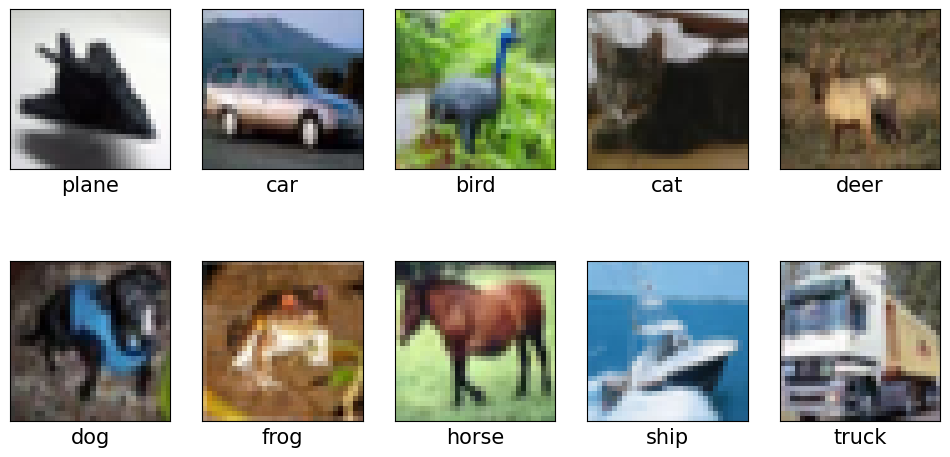

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# visualize training image for each class
sample_images = [dataset.data[np.asarray(dataset.targets) == label][0] for label in range(10)]
# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    axis.imshow(sample_images[i])
    i += 1

## Define CNN architecture

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 128, 5, padding=2)
    self.conv2 = nn.Conv2d(128, 128, 5, padding=2)
    self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
    self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.bn_conv1 = nn.BatchNorm2d(128)
    self.bn_conv2 = nn.BatchNorm2d(128)
    self.bn_conv3 = nn.BatchNorm2d(256)
    self.bn_conv4 = nn.BatchNorm2d(256)
    self.bn_dense1 = nn.BatchNorm1d(1024)
    self.bn_dense2 = nn.BatchNorm1d(512)
    self.dropout_conv = nn.Dropout2d(p=0.25)
    self.dropout = nn.Dropout(p=0.5)
    self.fc1 = nn.Linear(256 * 8 * 8, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 10)

  def conv_layers(self, x):
    out = F.relu(self.bn_conv1(self.conv1(x)))
    out = F.relu(self.bn_conv2(self.conv2(out)))
    out = self.pool(out)
    out = self.dropout_conv(out)
    out = F.relu(self.bn_conv3(self.conv3(out)))
    out = F.relu(self.bn_conv4(self.conv4(out)))
    out = self.pool(out)
    out = self.dropout_conv(out)
    return out

  def dense_layers(self, x):
    out = F.relu(self.bn_dense1(self.fc1(x)))
    out = self.dropout(out)
    out = F.relu(self.bn_dense2(self.fc2(out)))
    out = self.dropout(out)
    out = self.fc3(out)
    return out

  def forward(self, x):
    out = self.conv_layers(x)
    out = out.view(-1, 256 * 8 * 8)
    out = self.dense_layers(out)
    return out

net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)
net.to(device)

num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Number of trainable parameters:", num_params)

Device: cuda:0
Number of trainable parameters: 18617482


Hierarchical Softmax

In [ ]:
class HierarchicalSoftmax(nn.Module):
    def __init__(self, ntokens, nhid, ntokens_per_class = None):
        super(HierarchicalSoftmax, self).__init__()

        # Parameters
        self.ntokens = ntokens
        self.nhid = nhid

        if ntokens_per_class is None:
            ntokens_per_class = int(np.ceil(np.sqrt(ntokens)))

        self.ntokens_per_class = ntokens_per_class

        self.nclasses = int(np.ceil(self.ntokens * 1. / self.ntokens_per_class))
        self.ntokens_actual = self.nclasses * self.ntokens_per_class

        self.layer_top_W = nn.Parameter(torch.FloatTensor(self.nhid, self.nclasses), requires_grad=True)
        self.layer_top_b = nn.Parameter(torch.FloatTensor(self.nclasses), requires_grad=True)

        self.layer_bottom_W = nn.Parameter(torch.FloatTensor(self.nclasses, self.nhid, self.ntokens_per_class), requires_grad=True)
        self.layer_bottom_b = nn.Parameter(torch.FloatTensor(self.nclasses, self.ntokens_per_class), requires_grad=True)

        self.softmax = nn.Softmax(dim=1)

        self.init_weights()

    def init_weights(self):

        initrange = 0.1
        self.layer_top_W.data.uniform_(-initrange, initrange)
        self.layer_top_b.data.fill_(0)
        self.layer_bottom_W.data.uniform_(-initrange, initrange)
        self.layer_bottom_b.data.fill_(0)


    def forward(self, inputs, labels = None):

        batch_size, d = inputs.size()

        if labels is not None:

            label_position_top = labels / self.ntokens_per_class
            label_position_top = label_position_top.int()
            label_position_bottom = labels % self.ntokens_per_class

            layer_top_logits = torch.matmul(inputs, self.layer_top_W) + self.layer_top_b
            layer_top_probs = self.softmax(layer_top_logits)

            layer_bottom_logits = torch.squeeze(torch.bmm(torch.unsqueeze(inputs, dim=1), self.layer_bottom_W[label_position_top]), dim=1) + self.layer_bottom_b[label_position_top]
            layer_bottom_probs = self.softmax(layer_bottom_logits)

            target_probs = layer_top_probs[torch.arange(batch_size).long(), label_position_top] * layer_bottom_probs[torch.arange(batch_size).long(), label_position_bottom]

            return target_probs

        else:
            # Remain to be implemented
            layer_top_logits = torch.matmul(inputs, self.layer_top_W) + self.layer_top_b
            layer_top_probs = self.softmax(layer_top_logits)

            word_probs = layer_top_probs[:,0] * self.softmax(torch.matmul(inputs, self.layer_bottom_W[0]) + self.layer_bottom_b[0])

            for i in range(1, self.nclasses):
                word_probs = torch.cat((word_probs, layer_top_probs[:,i] * self.softmax(torch.matmul(inputs, self.layer_bottom_W[i]) + self.layer_bottom_b[i])), dim=1)

            return word_probs

## Training

In [ ]:
import torch.nn.functional as TF

def softmax_fn(output, labels, type):
  loss = 0
  if type == 'cross_entropy':
    softmax_probs = TF.softmax(outputs, dim=1) # P(y_h | X)
    loss = torch.mean(-torch.log(softmax_probs.gather(1, labels.view(-1,1)) )) # p(y_r|y_h)log (y_r | Y_h)

  elif type == 'gumbel':
    # https://pytorch.org/docs/stable/generated/torch.nn.functional.gumbel_softmax.html (pytorch gumbel softmax)
    softmax_probs = TF.gumbel_softmax(outputs, tau=1, hard=False).cuda()
    loss = torch.mean(-torch.log(softmax_probs.gather(1, labels.view(-1,1)) )) # p(y_r|y_h)log (y_r | Y_h)

  elif type == 'hierarchical':
    # https://github.com/leimao/Two-Layer-Hierarchical-Softmax-PyTorch/blob/master/main.py
    hierarchical_softmax = HierarchicalSoftmax(ntokens=10, nhid=10, ntokens_per_class=1).cuda()
    softmax_probs = hierarchical_softmax(output, labels.int())
    loss = torch.mean(-torch.log(softmax_probs)) # p(y_r|y_h)log (y_r | Y_h)
  elif type == 'adaptive':
    # https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveLogSoftmaxWithLoss.html (pytorch adaptive softmax)
    adaptive = torch.nn.AdaptiveLogSoftmaxWithLoss(in_features=10, n_classes=10, cutoffs=[1, 2, 3, 4, 5, 6, 7, 8, 9]).cuda()
    loss_total  = adaptive(output, labels).output
    loss = torch.mean(-loss_total)
  else :
    print(type + 'not found')

  return loss

In [ ]:
import torch.optim as optim
import torch
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=0)

loss_hist, acc_hist = [], []
loss_hist_val, acc_hist_val = [], []


softmax_type = 'hierarchical'

for epoch in range(20):
  running_loss = 0.0
  correct = 0
  for data in train_loader:
    batch, labels = data
    batch, labels = batch.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = net(batch)

    loss = softmax_fn(outputs, labels, type=softmax_type)
    ## loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # compute training statistics
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    running_loss += loss.item()

  avg_loss = running_loss / len(train_set)
  avg_acc = correct / len(train_set)
  loss_hist.append(avg_loss)
  acc_hist.append(avg_acc)

  # validation statistics
  net.eval()
  with torch.no_grad():
    loss_val = 0.0
    correct_val = 0
    for data in val_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      outputs = net(batch)

      loss = softmax_fn(outputs, labels, type=softmax_type)
       #loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      _, predicted = torch.max(outputs, 1)
      correct_val += (predicted == labels).sum().item()
      loss_val += loss.item()
    avg_loss_val = loss_val / len(val_set)
    avg_acc_val = correct_val / len(val_set)
    loss_hist_val.append(avg_loss_val)
    acc_hist_val.append(avg_acc_val)
  net.train()

  scheduler.step(avg_loss_val)
  print('[epoch %d] loss: %.5f accuracy: %.4f val loss: %.5f val accuracy: %.4f' % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[epoch 1] loss: 0.01802 accuracy: 0.1008 val loss: 0.01819 val accuracy: 0.1002
[epoch 2] loss: 0.01804 accuracy: 0.1009 val loss: 0.01819 val accuracy: 0.0903
[epoch 3] loss: 0.01802 accuracy: 0.0991 val loss: 0.01819 val accuracy: 0.0987
[epoch 4] loss: 0.01802 accuracy: 0.1011 val loss: 0.01819 val accuracy: 0.1009
[epoch 5] loss: 0.01802 accuracy: 0.0994 val loss: 0.01819 val accuracy: 0.0972
[epoch 6] loss: 0.01802 accuracy: 0.0992 val loss: 0.01819 val accuracy: 0.1021
[epoch 7] loss: 0.01802 accuracy: 0.1006 val loss: 0.01819 val accuracy: 0.1033
[epoch 8] loss: 0.01802 accuracy: 0.0993 val loss: 0.01819 val accuracy: 0.0944
[epoch 9] loss: 0.01802 accuracy: 0.0989 val loss: 0.01819 val accuracy: 0.0979
[epoch 10] loss: 0.01802 accuracy: 0.1006 val loss: 0.01819 val accuracy: 0.1020
[epoch 11] loss: 0.01802 accuracy: 0.0992 val loss: 0.01819 val accuracy: 0.0976
[epoch 12] loss: 0.01802 accuracy: 0.1007 val loss: 0.01819 val accuracy: 0.1021
[epoch 13] loss: 0.01802 accuracy: 0.

## Plotting training statistics

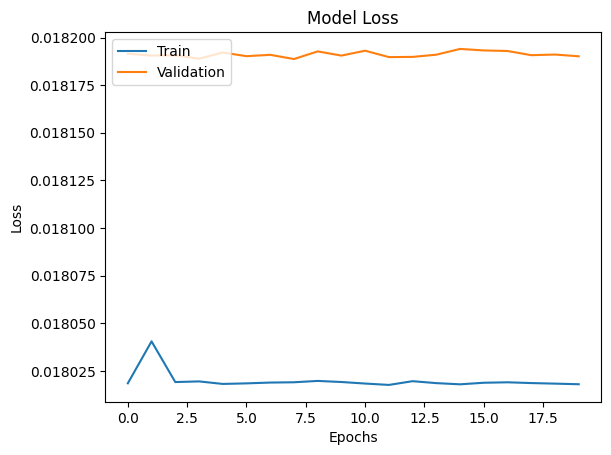

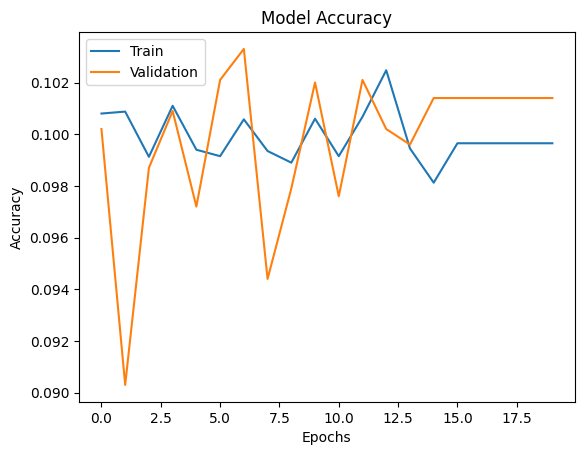

In [ ]:
import matplotlib.pyplot as plt

legend = ['Train', 'Validation']
plt.plot(loss_hist)
plt.plot(loss_hist_val)
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper left')
plt.show()
legend = ['Train', 'Validation']
plt.plot(acc_hist)
plt.plot(acc_hist_val)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper left')
plt.show()

## Save the trained model

In [ ]:
from google.colab import files

torch.save(net.state_dict(), softmax_type + '_checkpoint.pth')
# download checkpoint file
files.download(softmax_type + '_checkpoint.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
filePath = '/content/drive/MyDrive/hierarchical_checkpoint.pth'
net.load_state_dict(torch.load(filePath))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<All keys matched successfully>

## Testing

In [ ]:
pred_vec = []
correct = 0
net.eval()
with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = net(batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec.append(predicted)
    pred_vec = torch.cat(pred_vec)

print('Accuracy on the 10000 test images: %.2f %%' % (100 * correct / len(test_set)))

Accuracy on the 10000 test images: 10.00 %


## Visualize wrongly classified image for each class

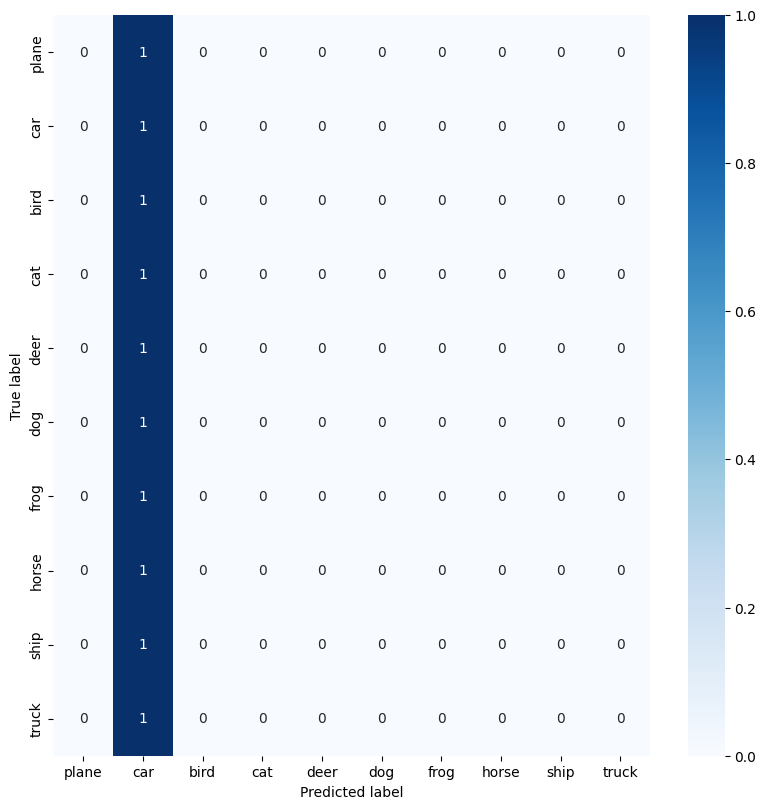

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# visualize wrongly classified image for each class
pred_vec = pred_vec.cpu().numpy()
ground_truths = np.asarray(test_set.targets)

con_mat = tf.math.confusion_matrix(labels=ground_truths, predictions=pred_vec).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes,
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()